In [1]:
!pip install -q sklearn
# Import tensorflow
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

from __future__ import absolute_import, division, print_function, unicode_literals
# Import python libraries
import numpy as np
import pandas as pd               # Pandas for data manipulation and analytics
import matplotlib.pyplot as plt   # Matplot lib for visualization
from IPython.display import clear_output # Clear notebook
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc  # Creates feature column

import tensorflow as tf

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
# Mount drive to access csv files in colab folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Data set
# path = "copied path"

dftrain = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Ipeds2016_TuitionFees_UndergradEnroll - Ipeds2016_TuitionFees_UndergradEnroll.csv') # training data
dfeval  = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Ipeds2017_TuitionFees_UndergradEnroll - Ipeds2017_TuitionFees_UndergradEnroll.csv') # testing data
y_train = dftrain.pop('Choice')
y_eval  = dfeval.pop('Choice')

CATEGORICAL_COLUMNS = ['University', 'Location', 'Mission']
NUMERIC_COLUMNS     = ['Tuition', 'TuitionIS','UndergradEnroll',]

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary    = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  #feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

# dftrain[feature_name].unique()

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='University', vocabulary_list=('Adrian College', 'Alaska Pacific University', 'Albany College of Pharmacy and Health Sciences', 'Alcorn State University', 'Alice Lloyd College', 'Allen University', 'American Academy of Dramatic Arts-New York', 'American International College', 'American Musical and Dramatic Academy', 'Andrew College', 'Antioch College', 'Antonelli Institute', 'Aquinas College', 'Argosy University-The Art Institute of California-Inland Empire', 'Arkansas Baptist College', 'Arkansas State University-Beebe', 'Arkansas State University-Main Campus', 'Art Academy of Cincinnati', 'Assumption College for Sisters', 'Auburn University at Montgomery', 'Augustana College', 'Averett University', 'Bais Binyomin Academy', 'Bais HaMedrash and Mesivta of Baltimore', 'Bais Medrash Toras Chesed', 'Baker University', 'Baldwin Wallace University', 'Baptist Bible College', 'Baptist Missionary Association Theological Se

In [ ]:
example = dict(dftrain.head(1))
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
dftrain.describe()

,Tuition,TuitionIS,UndergradEnroll
count,497.000000,497.000000,497.000000
mean,30346.649899,16577.241449,571.281690
std,14753.647036,12570.271515,978.663115
min,6819.000000,0.000000,1.000000
25%,18206.000000,6700.000000,74.000000
50%,25900.000000,12000.000000,233.000000
75%,39544.000000,24670.000000,590.000000
max,72717.000000,52383.000000,8232.000000


In [ ]:
dftrain.shape

(497, 6)

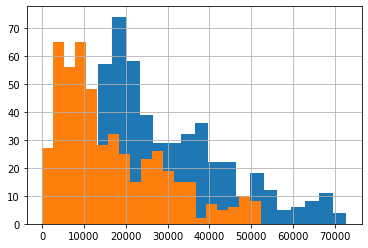

In [ ]:
dftrain.Tuition.hist(bins=20)
dftrain.TuitionIS.hist(bins=20)

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)



In [ ]:
# Create Estimator
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpy8d1obyb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

# clears console output
clear_output()  

# the result variable is simply a dict of stats about our model


In [ ]:
print(pd.Series(result))

accuracy                  0.875000
accuracy_baseline         0.888889
auc                       0.528103
auc_precision_recall      0.131987
average_loss            110.813858
label/mean                0.111111
loss                    109.290062
precision                 0.285714
prediction/mean           0.031907
recall                    0.083333
global_step             160.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpy8d1obyb/model.ckpt-160
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


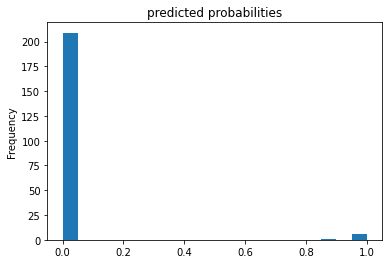

In [ ]:
# Create list of results
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()


In [ ]:
# Gradient boosting using: Boosted Trees
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.861111
accuracy_baseline         0.888889
auc                       0.597765
auc_precision_recall      0.210791
average_loss              0.596208
label/mean                0.111111
loss                      0.593034
precision                 0.250000
prediction/mean           0.103332
recall                    0.125000
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpt8no0e3p/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


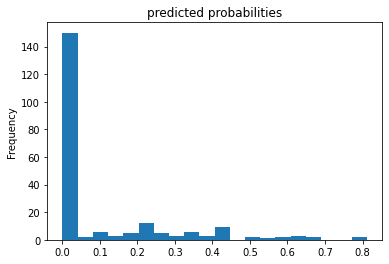

In [ ]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

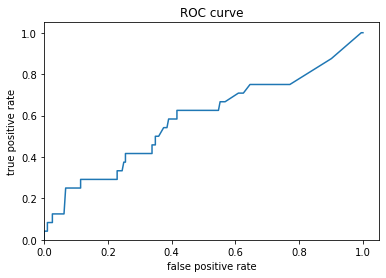

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [ ]:
# Create list of results
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()
# Print Specified results based on location
print(dfeval.loc[0])
print(y_eval.loc[0])
print(result[0]['probabilities'][1])